# DeepDream Implementation

In [1]:
# Import relevant libraries
import torch
import requests, tqdm

import numpy as np

from torchvision import models, transforms
from torch.autograd import Variable
from PIL import Image, ImageChops, ImageFilter

import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline

Preprocessing and deprocessing of the input.

In [25]:
def deprocess(image):
  """
  image : (3, 512, 512)
  """
  return (image*torch.tensor([0.229, 0.224, 0.225]).cuda() + torch.tensor([0.485, 0.456, 0.406]).cuda()).cpu().numpy()

def preprocess(image, type = 'vgg'):
  normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
  if type == 'vgg':
    prep = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), normalize])
  elif type == 'alex':
    prep = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor(), normalize])
  return prep(image)

def load_image(path):
  image = Image.open(path)
  return image

def tensor2image(tensor):
  tensor = tensor.data.squeeze()
  tensor = tensor.transpose(0, 1)
  tensor = tensor.transpose(1, 2)
  tensor = np.clip(deprocess(tensor), 0, 1)
  return Image.fromarray(np.uint8(tensor*255))


Get features from model.

In [3]:
def get_features(model = 'vgg'):
  if model in ['vgg', 'VGG', 'vgg16', 'VGG16']:
    model = models.vgg16(pretrained = True).cuda()
    return list(model.features.modules())
  elif model in ['alex', 'alexnet', 'ALEX', 'ALEXNET']:
    model = models.alexnet(pretrained = True).cuda()
    return list(model.features.modules())
  else:
    raise NameError(f'model {model} not yet supported !')

step function that performs gradient ascent on an image to maximize feature activations.

In [42]:
def step(img, layer_id, n_iter, lr, model = 'vgg'):
  # cast image to a tensor with gradients enabled.
  input = Variable(preprocess(img)[None].cuda(), requires_grad = True)

  # define optimizer that will output the gradients.
  optimizer = torch.optim.Adam([input], lr = lr, amsgrad = True)
  optimizer.zero_grad()
  for i in tqdm.tqdm(range(n_iter)):
    features = input
    for j in range(1, layer_id + 1):
      features = modulelist[j](features)
    
    # calculate loss.
    loss = features.norm()
    loss.backward()
    optimizer.step()

    # Perform gradient ascent.
    input.data = input.data + lr*input.grad.data/input.grad.data.std()

  # Get image from grad-enabled tensor.
  new_image = tensor2image(input)

  return new_image



Define deep dream function that iteratively performs the step function on the image through various sizes defined in the pyramid and updates by blending.

In [43]:
def deepdream(img, layer_id, n_iter, lr, f, depth, blend_factor = .6, model = 'vgg'):
  original_size = img.size

  if depth > 0:
    im_1 = img.filter(ImageFilter.GaussianBlur(2))

    # get size in of image in the next pyramid level.
    new_size = int(im_1.size[0]/f), int(im_1.size[1]/f) if (im_1.size[0]/f > 1 and im_1.size[1]/f > 1) else im_1.size
    
    # set image to new size and go to the next pyramid level.
    im_1 = im_1.resize(new_size, Image.ANTIALIAS)
    im_1 = deepdream(im_1, layer_id, n_iter, lr, f, depth - 1, blend_factor, model = model)

    # transforms image to original size to blend it with parent in the pyramid.
    im_1 = im_1.resize(original_size, Image.ANTIALIAS)
    img = ImageChops.blend(img, im_1, blend_factor)

  # when all children in pyramid have been taken into account, step on current level.
  im_asc = step(img, layer_id, n_iter, lr, model = model)
  
  plt.figure()
  plt.imshow(im_asc)
  plt.title(f'depth = {depth}')
  
  return im_asc.resize(original_size) 

# test algorithm on an image from the internet.

load the model features and checkout which one we want to maximize.

In [37]:
modulelist = get_features('alexnet')

In [41]:
for _i, m in enumerate(modulelist):
  print(_i, '-->', m)

0 --> Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)
1 --> Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
2 --> ReLU(inplace=True)
3 --> MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
4 --> Conv2d(64, 192, kernel_size=(5, 5), stride=

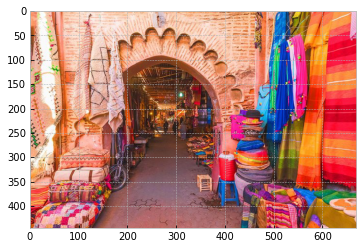

In [48]:
# image_example = "https://images.photowall.com/products/69237/lion-close-up.jpg?h=699&q=85"
image_example = "https://media.tacdn.com/media/attractions-splice-spp-674x446/09/f7/05/90.jpg"
im = Image.open(requests.get(image_example, stream = True).raw)
plt.imshow(im)

100%|██████████| 40/40 [00:00<00:00, 633.53it/s]


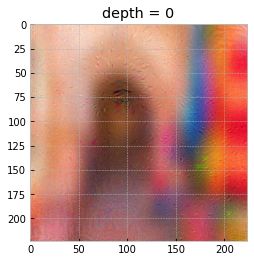

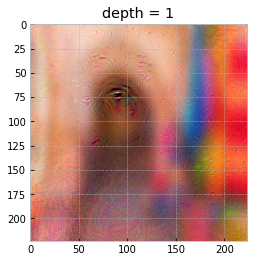

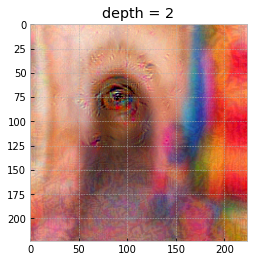

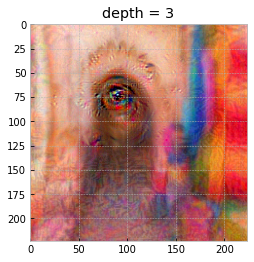

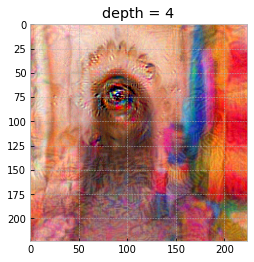

In [52]:
result = deepdream(im, 11, 40, 0.005, 2, 4, blend_factor = .8, model = 'alex')

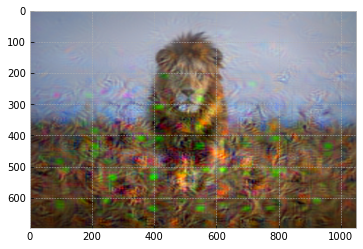

In [22]:
plt.imshow(result)